# Electricity Consumption Forecasting

## Author: David Xiong

## 1. Excutive Summary

### Decisions to be impacted
This project’s electricity consumption forecasting model is crucial for power supply planning, allowing energy providers to allocate resources proactively and manage demand effectively. It aids in adjusting production schedules and distribution channels, contributing to grid stability and resilience against demand spikes. By providing accurate predictions, energy companies can anticipate high usage periods and optimize their operations to meet these peaks without overproducing, thus lowering costs. The insights generated help prioritize maintenance schedules for infrastructure to reduce downtime and prepare for seasonal demand variations. Moreover, energy providers can better evaluate when to integrate renewable energy sources, balancing traditional and sustainable power solutions. This approach not only benefits business efficiency but also supports broader environmental goals by reducing waste and lowering the carbon footprint.

### Business Value
Forecasting electricity consumption adds business value by improving energy efficiency, reducing waste, and cutting operational costs, directly benefiting energy providers. Accurate predictions lead to optimized resource allocation, limiting unnecessary power production, which helps conserve natural resources and reduces environmental impact. It enables businesses to deliver consistent, reliable energy to consumers, fostering trust and enhancing customer satisfaction. From a societal perspective, the model supports grid stability, which is critical for maintaining essential services during peak times. It further aligns with sustainable energy policies by facilitating the adoption of renewable energy sources, contributing to climate change mitigation. Through precise energy planning, communities benefit from fewer power outages, reduced costs, and improved quality of life.

### Data Assets
The dataset for this project is the UCl individual Household Electric Power Consumption dataset, which contains detailed measurements of a single household's electricity usage in Sceaux, a French town that is 7 km away from Paris. The dataset consists of two millions records collected at one-minute intervals between December 2006 and November 2010. lt includes variables such as time, global active power, global reactive power, voltage, and sub-metering values that are important for developing a time series forecasting model.

## 2. Data Preprocessing

### Data Description
The dataset comprises 2,075,259 measurements of household electricity consumption in one-minute intervals over four years. Features include: **‘Date’** (dd/mm/yyyy), **‘Time’** (hh:mm:ss), **‘Global_active_power’** (household global minute-averaged active power (in kilowatts)), **‘Global_reactive_power’** (household global minute-averaged reactive power (in kilowatts)), **‘Voltage’** (minute-averaged voltage (in volts)), **‘Global_intensity’** (household global minute-averaged current intensity (in amperes)), **‘Sub_metering_1’** (corresponds to kitchen appliances like the dishwasher, oven, and microwave (in watt-hours of active energy)), **‘Sub_metering_2’** (corresponds to laundry appliances, including the washing machine, refrigerator, and tumble dryer (in watt-hours of active energy)), **‘Sub_metering_3’** (corresponds to an electric water heater and air conditioner (in watt-hours of active energy)), and the generated feature **‘active_energy_consumed’** (represents the active energy consumed every minute (in watt hour)) by the formula below:

**active_energy_consumed** = (Global active power × 1000) / 60 - Sub metering values

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

matplotlib.use('TkAgg')

### Data Preprocessing Steps
**Handling Missing Values**

Missing values were identified in the dataset, represented by "?". These missing entries were filled using forward fill (ffill), in which missing values are filled by propagating the most recent non-missing value forward, to ensure time series continuity

In [2]:
# import data
data=pd.read_table('household_power_consumption.txt',sep=';',na_values='?')
data = data.fillna(method='ffill') #
# global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3
data['active_energy_consumed']=data['Global_active_power'].astype(float)*1000/60-data['Sub_metering_1']-data['Sub_metering_2']-data['Sub_metering_3']

**Datetime Processing**

The dataset originally included separate columns for Date and Time. To create a continuous time series representation: The Date and Time columns were combined to create a datetime object using the pd.to_datetime() function. Then there are three new columns generated: Year, Month, and Day. For the ‘day’ column, 0-6 represents weekdays from Monday to Sunday.

**Creating Daily Aggregated Data**

Created and selected the relevant columns, including Date, Year, Month, Day, and the derived column for active energy consumed (active_energy_consumed). Grouped the dataset by Date to calculate daily averages for each feature, converted the Date column back into a datetime format and sorted the data chronologically.

In [3]:
# create the daily data
dttime_temp=pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.insert(2, 'Year',dttime_temp.dt.year) #year
data.insert(3, 'Month',dttime_temp.dt.month) #month
data.insert(4, 'Day',dttime_temp.dt.weekday) #weekday_name
data_clean=data.iloc[:,[0,2,3,4,12]]
data_clean=data_clean.groupby('Date',as_index=False).mean()
data_clean['Date']=pd.to_datetime(data_clean['Date'],format='%d/%m/%Y')
data_clean=data_clean.sort_values(by='Date')

In [4]:
data_clean.head(30)

,Date,Year,Month,Day,active_energy_consumed
341,2006-12-16,2006.0,12.0,5.0,37.073064
389,2006-12-17,2006.0,12.0,6.0,25.657407
437,2006-12-18,2006.0,12.0,0.0,13.214190
485,2006-12-19,2006.0,12.0,1.0,9.119375
580,2006-12-20,2006.0,12.0,2.0,14.156111
628,2006-12-21,2006.0,12.0,3.0,9.589954
676,2006-12-22,2006.0,12.0,4.0,16.937708
724,2006-12-23,2006.0,12.0,5.0,42.872523
772,2006-12-24,2006.0,12.0,6.0,20.016806
820,2006-12-25,2006.0,12.0,0.0,21.765046


In [5]:
# EDA
# summary description
data_clean['active_energy_consumed'].describe()

count    1442.000000
mean        9.301362
std         4.310367
min         1.433333
25%         6.471319
50%         8.736551
75%        11.478050
max        42.872523
Name: active_energy_consumed, dtype: float64

Per the variable distribution, we can see the mean daily active_energy_consumed is about 9.3 and the standard deviation is 4.31, indicating a moderate variability. Besides, 25th percentile (6.47), median (8.74), and 75th percentile (11.48) show that the data is skewed, with the upper quartile containing higher consumption values.

### Visualizations and Summary

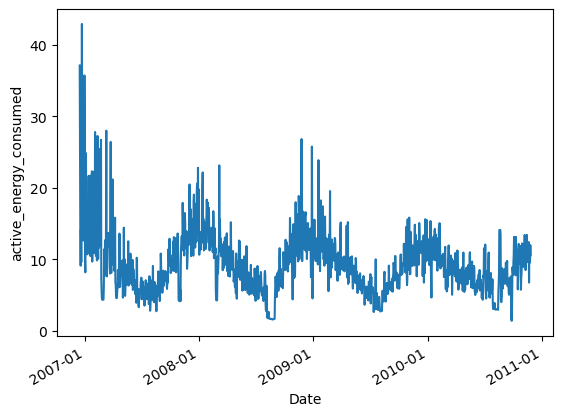

In [6]:
# first visualization
sns.lineplot(x=data_clean['Date'],y=data_clean['active_energy_consumed'])

# Improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks at yearly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format tick labels as Year-Month

# Rotate labels for better readability
plt.gcf().autofmt_xdate()

%matplotlib inline
plt.show()

This graph displays the daily active energy consumption in watt-hours over four years. It shows a high initial consumption in early 2007, followed by a gradual decline and periodic fluctuations. Seasonal patterns emerge with higher usage in winter and lower usage in summer, reflecting temperature-dependent consumption.

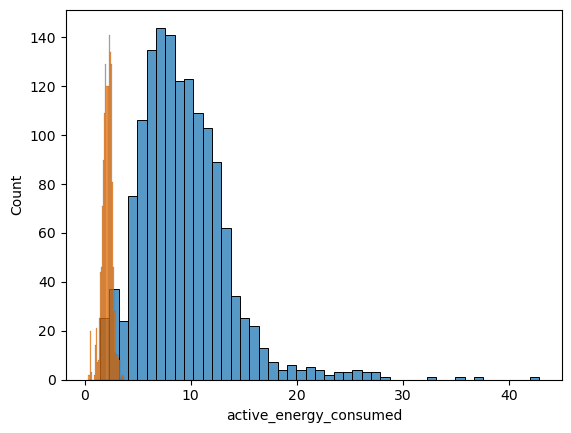

In [7]:
# histogram
sns.histplot(data_clean['active_energy_consumed'])
sns.histplot(np.log(data_clean['active_energy_consumed']))
# thus log-transformation is performed
data_clean['active_energy_consumed_log']=np.log(data_clean['active_energy_consumed'])

%matplotlib inline
plt.show()

This histogram shows the distribution of daily active energy consumption, with most values concentrated in the interval between 0 and 10 watt-hours. The right-skewed shape indicates a few high-consumption outliers, suggesting that extreme energy usage is rare. The log transformation was applied to stabilize variance and normalize the data.

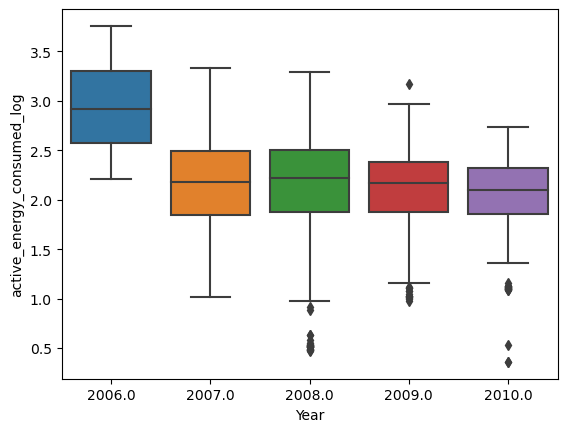

In [8]:
# relationship between active_energy_consumed and years\month\day
sns.boxplot(x=data_clean['Year'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot shows the log-transformed ‘active_energy_consumption’ across years from 2006 to 2010. Median consumption remains relatively stable except for 2006, but outliers appear consistently below each year's range, particularly in 2008 and 2009. Consumption variability decreases slightly over time, with 2006 showing the highest spread.

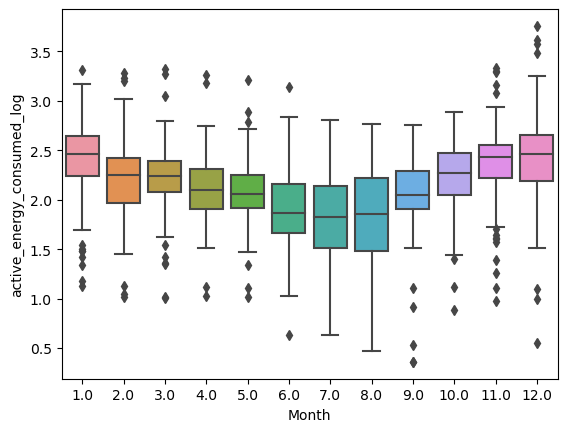

In [9]:
sns.boxplot(x=data_clean['Month'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot displays monthly trends in log-transformed active energy consumption, revealing clear seasonal variations. Winter months, particularly January, November, and December, exhibit higher median consumption and larger interquartile ranges, reflecting increased energy use and greater variability during colder months. This pattern is likely due to higher heating demands. In contrast, summer months, especially July and August, show lower median consumption and fewer outliers, suggesting reduced energy needs, possibly due to less reliance on heating systems. Outliers are present across most months, but winter months have more extreme values, highlighting peak energy demands during colder periods of the year.

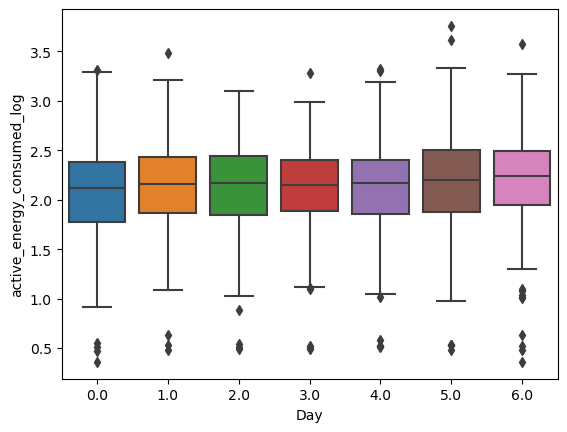

In [10]:
sns.boxplot(x=data_clean['Day'],y=data_clean['active_energy_consumed_log'])
plt.show()

This box plot shows log-transformed active energy consumption by day of the week, from Monday (0) to Sunday (6). Median consumption is relatively consistent across all days, with slightly higher usage mid-week. Outliers are present every day, though weekends have more, suggesting occasional peak demands outside the regular weekday pattern.

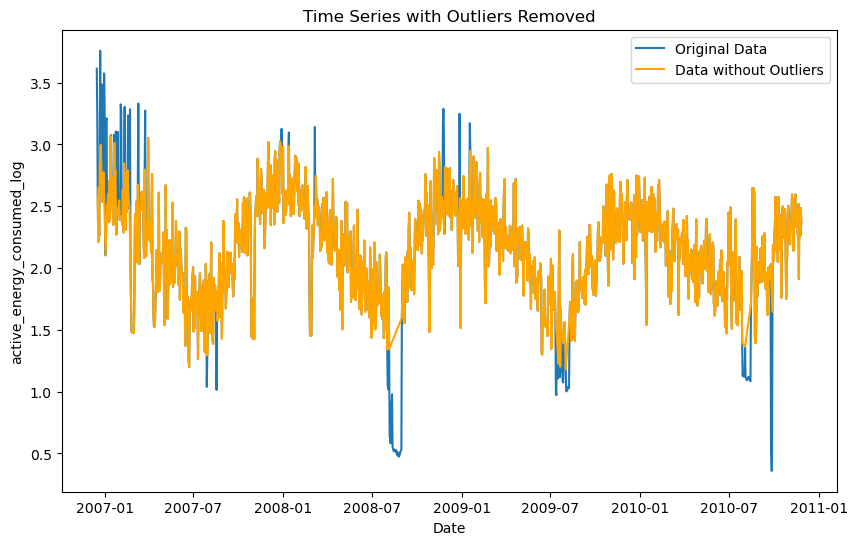

In [11]:
data_clean['Z_score'] = np.abs(stats.zscore(data_clean['active_energy_consumed_log']))

# Filter out data points where the Z-score is greater than 2
threshold = 2
data_clean_no_outliers = data_clean[data_clean['Z_score'] < threshold]

# Plot the cleaned data
plt.figure(figsize=(10, 6))
plt.plot(data_clean['Date'], data_clean['active_energy_consumed_log'], label='Original Data')
plt.plot(data_clean_no_outliers['Date'], data_clean_no_outliers['active_energy_consumed_log'], label='Data without Outliers', color='orange')
plt.title('Time Series with Outliers Removed')
plt.xlabel('Date')
plt.ylabel('active_energy_consumed_log')
plt.legend()
plt.show()

I used the **Z-score** approach to detect outliers by calculating the absolute Z-score of each data point in active_energy_consumed_log. Data points with a Z-score greater than the threshold of 2 are identified as outliers and removed. The graph shows the original data in blue and the cleaned data in orange, which effectively reduces the impact of extreme values, making trends more visible.

## 3. Modeling Approach

A **linear regression model** was initially implemented to predict log-transformed daily electricity consumption. The residual analysis showed autocorrelation, suggesting that time series models like SARlMA are more appropriate.

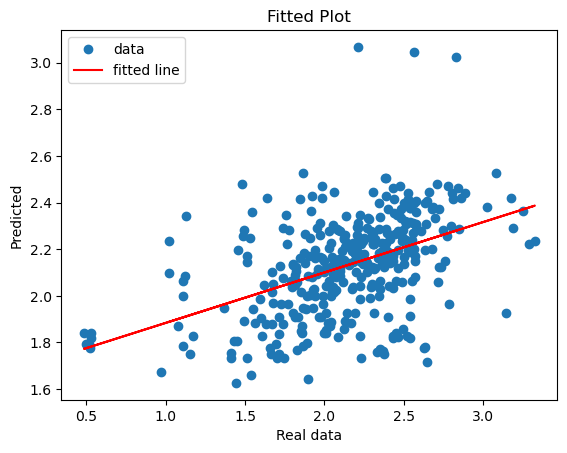

0.20980864230535695

In [12]:
# Raw model (linear Regression)
x = data_clean[['Year','Month','Day']]
x = pd.get_dummies(x.astype('str'),drop_first=True)
y = data_clean['active_energy_consumed_log']
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.xlabel('Real data')
plt.title('Fitted Plot')
plt.ylabel('Predicted')
plt.show()
# r2
r_value**2 # R2=0.210

**Residual Plot:** A plot of residuals was created to evaluate the linear regression model's performance. The R² value of 0.21 indicates that the linear model explains only 21% of the variance in the observed data. This low R² suggests a weak fit, meaning that the model does not capture most of the variability in actual energy consumption values. The residual plot revealed autocorrelation, indicating the need for a time series model. 

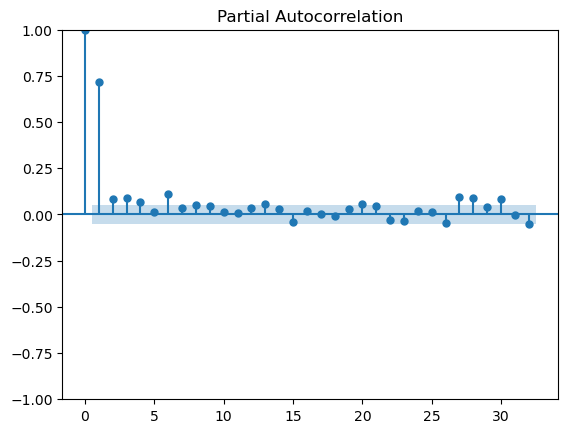

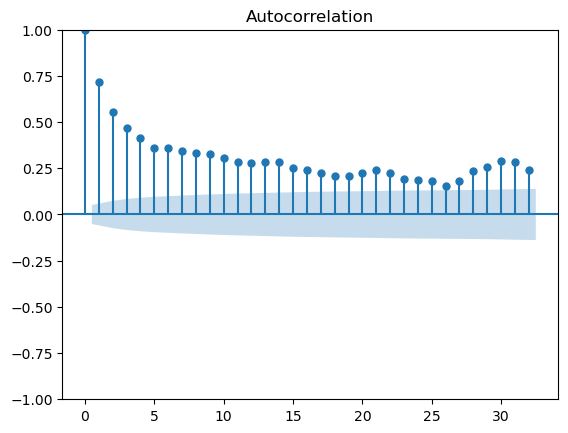

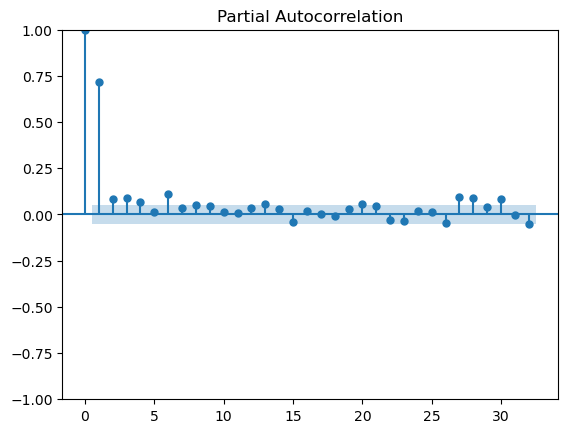

In [13]:
# Autocorrelation in residuals
model = lm.fit(x, y)
residuals = lm.predict(x)-y
sm.graphics.tsa.plot_acf(residuals)
sm.graphics.tsa.plot_pacf(residuals)

# autocorrelation is existed, which shows the time series model such as sarima is needed in the next step

### SARIMA

The SARIMA approach was initiated with descriptive analytics to examine historical patterns in electricity consumption. Seasonal decomposition identified recurring variations influenced by temporal factors such as the time of year and day of the week. Ensuring data quality was critical; outliers were identified and removed using Z-score analysis, effectively reducing the impact of extreme values. Additionally, a log transformation was applied to stabilize the variability of the consumption data and normalize the dataset, making it more suitable for modeling. These preprocessing steps provided a clear understanding of the dataset’s structure, laying a robust foundation for predictive modeling.

SARIMA was chosen for its capability to model both seasonal and non-seasonal components in time series data. To meet the stationarity requirement, seasonal differencing was applied, and the Augmented Dickey-Fuller (ADF) test confirmed this condition. Seasonal decomposition further facilitated the isolation of trend, seasonal, and residual components, improving the model's interpretability. Hyperparameter tuning was conducted through a comprehensive grid search over defined ranges of ARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, s). The Akaike Information Criterion (AIC) was used to identify the optimal configuration, resulting in the best-fit model with parameters (5, 1, 4) for ARIMA and (0, 1, 1, 7) for the seasonal component. This model effectively captured short-term dependencies and long-term seasonal trends in the dataset.

To evaluate the SARIMA model, cross-validation was employed by splitting the dataset into training and testing sets. The model was trained on data from 2007 to 2009, while predictions were validated against the last two months of 2010. Rolling forecasts were implemented to assess the model’s generalizability across multiple prediction horizons. However, the SARIMA model yielded an R-squared value of 0.11, reflecting limited predictive accuracy. This outcome underscored challenges in fully capturing the complexities of electricity consumption dynamics and pointed to the need for further model refinements or alternative approaches.

In [14]:
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error

In [15]:
# Train and Test
# using the 2 month of 2010 as test
train = data_clean[(data_clean['Year'] >= 2007) & (data_clean['Year'] <= 2010)]
test = data_clean[(data_clean['Year'] == 2010) & (data_clean['Month']>=10)]

In [16]:
mod = SARIMAX(train['active_energy_consumed'], order=(5, 1, 4),
                                seasonal_order=(0, 1, 1, 7), # The seasonal effect can be considered as the month
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
predictions = results.forecast(steps=test.shape[0])

# Result
Result=pd.DataFrame({'Prediction': list(predictions),
                     'Real_value': list(test['active_energy_consumed'])})
Result['Residuals']=Result['Real_value']-Result['Prediction']

/Users/daivd/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daivd/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40728D+00    |proj g|=  1.32937D-01

At iterate    5    f=  2.28933D+00    |proj g|=  4.02001D-02

At iterate   10    f=  2.28280D+00    |proj g|=  1.87248D-02

At iterate   15    f=  2.28195D+00    |proj g|=  2.25719D-02

At iterate   20    f=  2.28036D+00    |proj g|=  4.32212D-02

At iterate   25    f=  2.27980D+00    |proj g|=  4.16835D-03

At iterate   30    f=  2.27852D+00    |proj g|=  2.49407D-02

At iterate   35    f=  2.27830D+00    |proj g|=  2.47001D-03

At iterate   40    f=  2.27829D+00    |proj g|=  1.62077D-03

At iterate   45    f=  2.27828D+00    |proj g|=  2.90615D-03

At iterate   50    f=  2.27826D+00    |proj g|=  3.97405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/daivd/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daivd/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daivd/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


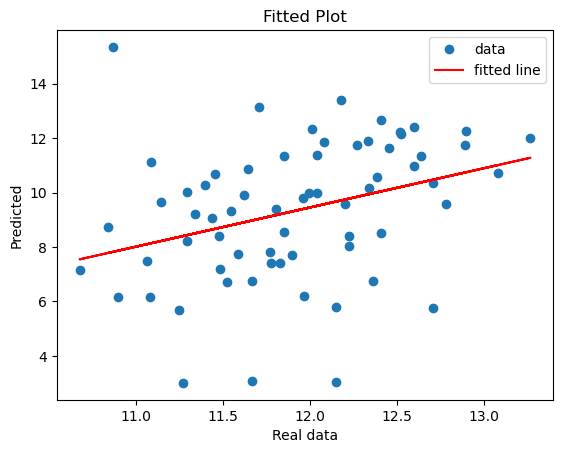

0.11026423795849988

In [17]:
# Visualization
slope, intercept, r_value, p_value, std_err = stats.linregress(Result['Prediction'],
                                                               Result['Real_value'])

plt.plot(Result['Prediction'], Result['Real_value'], 'o', label='data')
plt.plot(Result['Prediction'], intercept + slope*Result['Prediction'], 'r', label='fitted line')
plt.legend()
plt.xlabel('Real data')
plt.title('Fitted Plot')
plt.ylabel('Predicted')
plt.show()
# r2
r_value**2

### Prophet

The Prophet model was adopted as a complementary approach to SARIMA, leveraging its flexibility and scalability for time series forecasting. Multiple iterations were implemented to refine its performance and adapt it to the specific characteristics of the electricity consumption dataset.

The first iteration employed Prophet’s default settings, utilizing yearly and weekly seasonality to capture overarching patterns and periodic behaviors. While this configuration successfully modeled general trends, the evaluation metrics—R² and RMSE—indicated moderate predictive accuracy. As a baseline, this iteration provided a valuable reference for Prophet’s potential in handling electricity consumption data, while also highlighting the need for further refinement.

In the second iteration, holiday data was integrated into the model as additional regressors to account for deviations in consumption patterns on significant dates such as Christmas and New Year. By defining upper and lower windows, the model captured the effects of holidays and adjacent days. This adjustment enhanced the model’s ability to predict anomalies during holiday periods, though the overall improvements in accuracy were incremental rather than transformative.

The third iteration incorporated weather variables, specifically temperature and humidity, as external regressors. This step aimed to account for external influences on electricity usage, such as increased consumption during extreme weather conditions. However, the metrics showed minimal improvement, suggesting that the relationship between weather and electricity usage may be more nuanced. These findings pointed to the need for additional data or advanced techniques to effectively integrate weather-related factors.

The fourth iteration introduced a weekly recursive forecasting approach. For each week in 2010, the model was trained on data from 2007 to the preceding week of the test set, updating the training data dynamically after each forecast. This strategy allowed the model to refine its predictions iteratively with recent data. While this approach improved temporal adaptability and provided more robust evaluations, it struggled to accurately capture abrupt changes in consumption patterns.

In the final iteration, time-series cross-validation was employed using Prophet’s built-in utility. The dataset was divided into an initial two-year training set (2007-2008), with forecasts generated every six months (180 days) and evaluated over a one-year horizon. This cross-validation approach simulated multiple forecasting scenarios, providing a systematic framework for performance evaluation. Metrics such as RMSE, MSE, and MAPE revealed areas requiring further optimization while confirming the model’s ability to effectively capture trends and seasonality. This iteration underscored Prophet’s robustness and adaptability, while also highlighting its limitations in modeling complex and dynamic relationships.

In [18]:
from prophet import Prophet
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
train = data_clean[(data_clean['Year'] >= 2007) & (data_clean['Year'] < 2010)]
train_ts=train[['Date','active_energy_consumed_log']].rename(columns={'Date':'ds','active_energy_consumed_log':'y'})
test = data_clean[(data_clean['Year'] == 2010)]
test_ts=test[['Date','active_energy_consumed_log']].rename(columns={'Date':'ds','active_energy_consumed_log':'y'})

In [20]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_ts)

future = model.make_future_dataframe(periods=test_ts.shape[0])
forecast = model.predict(future)

forecast1 = forecast[(forecast['ds']<'2010-01-01')]
forecast2 = forecast[(forecast['ds']>='2010-01-01')]
slope, intercept, r_value, p_value, std_err = stats.linregress(forecast2['yhat'],
                                                               test['active_energy_consumed_log'])

r_value**2

10:44:27 - cmdstanpy - INFO - Chain [1] start processing
10:44:27 - cmdstanpy - INFO - Chain [1] done processing


0.3606206496324975

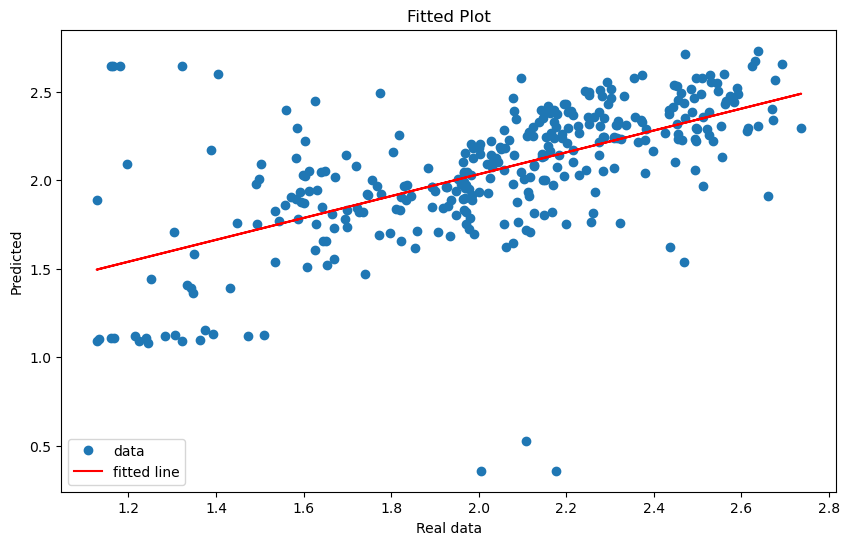

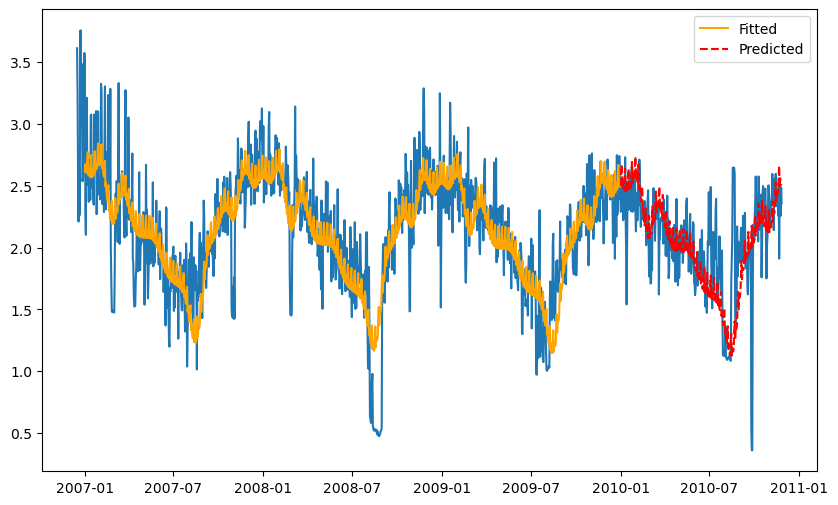

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(forecast2['yhat'], test['active_energy_consumed_log'], 'o', label='data')
plt.plot(forecast2['yhat'], intercept + slope*forecast2['yhat'], 'r', label='fitted line')
plt.legend()
plt.xlabel('Real data')
plt.title('Fitted Plot')
plt.ylabel('Predicted')
plt.show()

# fitted and predicted
plt.figure(figsize=(10, 6))
plt.plot(data_clean['Date'], data_clean['active_energy_consumed_log'])
plt.plot(forecast1['ds'], forecast1['yhat'],linestyle='-',color='orange',label='Fitted')
plt.plot(forecast2['ds'], forecast2['yhat'],linestyle='--',color='red',label='Predicted')
plt.legend()

### 2nd Prophet Model, adding holidays data

In [22]:
# Step 1: Seasonal Decomposition and Smoothing
decomposition = seasonal_decompose(train_ts['y'], model='additive', period=365)
train_ts['y_smoothed'] = decomposition.trend.dropna()

In [23]:
# Step 2: Define Holidays
holidays = pd.DataFrame({
    'holiday': 'public_holiday',
    'ds': pd.to_datetime([
        # Christmas Holidays
        '2007-12-25', '2008-12-25', '2009-12-25', '2010-12-25',
        # New Year Holidays
        '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
        # Independence Day (for example)
        '2007-07-04', '2008-07-04', '2009-07-04', '2010-07-04',
        # Labor Day (first Monday of September in US)
        '2007-09-03', '2008-09-01', '2009-09-07', '2010-09-06',
        # Thanksgiving (fourth Thursday of November in US)
        '2007-11-22', '2008-11-27', '2009-11-26', '2010-11-25',
        # Easter (varies by year)
        '2007-04-08', '2008-03-23', '2009-04-12', '2010-04-04',
        # Valentine's Day (increased electricity use for events)
        '2007-02-14', '2008-02-14', '2009-02-14', '2010-02-14',
        # Black Friday (retail stores, potentially high electricity use)
        '2007-11-23', '2008-11-28', '2009-11-27', '2010-11-26',
        # Summer Vacation Start (beginning of summer)
        '2007-06-01', '2008-06-01', '2009-06-01', '2010-06-01',
        # Winter Holiday Start (peak home usage during winter)
        '2007-12-20', '2008-12-20', '2009-12-20', '2010-12-20'
    ]),
    'lower_window': 0,  # Start from the same day
    'upper_window': 1   # Extend the effect to the next day
})

# Add to the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays
)

In [24]:
# Define and Tune the Prophet Model

# Check for duplicate dates in the training data
duplicates = train_ts[train_ts.duplicated(subset=['ds'], keep=False)]
if not duplicates.empty:
    print("Duplicate dates found. Aggregating data...")
    # Aggregate by taking the mean of 'y' for duplicate dates
    train_ts = train_ts.groupby('ds', as_index=False).mean()

# Define the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,  # Adjust trend flexibility
    seasonality_prior_scale=10.0,  # Adjust seasonality flexibility
    holidays=holidays
)

# Add custom monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Optional: Add custom changepoints
changepoints = pd.to_datetime(['2008-06-01', '2009-07-01'])  # Example changepoints
model.changepoints = changepoints

# Fit the model using the cleaned data
try:
    model.fit(train_ts.dropna(subset=['y']))
except ValueError as e:
    print(f"Error during model fitting: {e}")

10:44:27 - cmdstanpy - INFO - Chain [1] start processing
10:44:27 - cmdstanpy - INFO - Chain [1] done processing
10:44:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:44:27 - cmdstanpy - INFO - Chain [1] start processing
10:44:28 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Step 4: Forecasting
future = model.make_future_dataframe(periods=test_ts.shape[0])
forecast = model.predict(future)

# Split forecasts into train and test predictions
forecast_train = forecast[forecast['ds'] < '2010-01-01']
forecast_test = forecast[forecast['ds'] >= '2010-01-01']

In [26]:
# Step 5: Evaluate the Model
slope, intercept, r_value, p_value, std_err = stats.linregress(forecast_test['yhat'], test_ts['y'])
print("Updated R² value:", r_value**2)

# RMSE calculation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_ts['y'], forecast_test['yhat'], squared=False)
print("RMSE:", rmse)

Updated R² value: 0.36204885913951906
RMSE: 0.34726692130496045


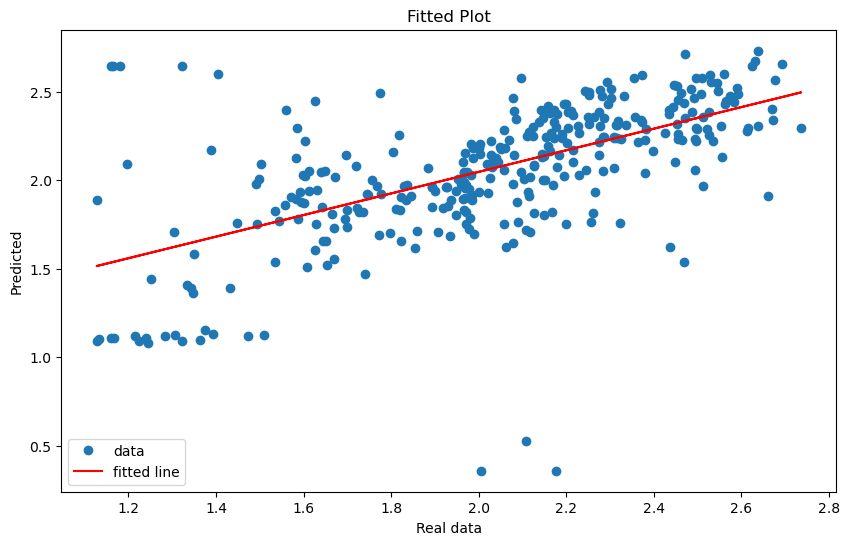

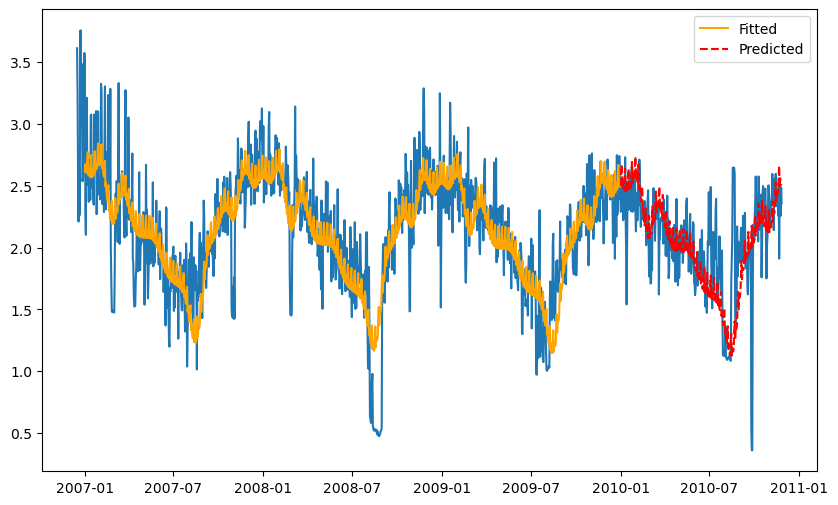

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(forecast2['yhat'], test['active_energy_consumed_log'], 'o', label='data')
plt.plot(forecast2['yhat'], intercept + slope*forecast2['yhat'], 'r', label='fitted line')
plt.legend()
plt.xlabel('Real data')
plt.title('Fitted Plot')
plt.ylabel('Predicted')
plt.show()

# fitted and predicted
plt.figure(figsize=(10, 6))
plt.plot(data_clean['Date'], data_clean['active_energy_consumed_log'])
plt.plot(forecast1['ds'], forecast1['yhat'],linestyle='-',color='orange',label='Fitted')
plt.plot(forecast2['ds'], forecast2['yhat'],linestyle='--',color='red',label='Predicted')
plt.legend()

### 3rd Prophet Model, adding weather data

In [28]:
from meteostat import Point, Daily
from itertools import product
from prophet.diagnostics import performance_metrics, cross_validation

In [29]:
# Gather Weather Data
location = Point(48.8566, 2.3522)  # Use Paris
start = datetime(2007, 1, 1)
end = datetime(2010, 12, 31)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

weather_data = weather_data[['tavg', 'pres']]  # Avg Temp (tavg) Air Pressure (pres)

data_clean = data_clean.merge(weather_data, left_on='Date', right_index=True, how='left')

In [30]:
# Forwardfill
data_clean['tavg'] = data_clean['tavg'].fillna(method='ffill')
data_clean['pres'] = data_clean['pres'].fillna(method='ffill')

data_clean = data_clean.dropna(subset=['pres'])

print(data_clean[data_clean['pres'].isna()])

train = data_clean[(data_clean['Year'] >= 2007) & (data_clean['Year'] < 2010)]
test = data_clean[data_clean['Year'] == 2010]

train_ts = train[['Date', 'active_energy_consumed_log', 'tavg', 'pres']].rename(columns={'Date': 'ds', 'active_energy_consumed_log': 'y'})
test_ts = test[['Date', 'active_energy_consumed_log', 'tavg', 'pres']].rename(columns={'Date': 'ds', 'active_energy_consumed_log': 'y'})

Empty DataFrame
Columns: [Date, Year, Month, Day, active_energy_consumed, active_energy_consumed_log, Z_score, tavg, pres]
Index: []


In [31]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 10.0, 20.0]
}

best_params = None
best_rmse = float('inf')

for cps, sps in product(param_grid['changepoint_prior_scale'], param_grid['seasonality_prior_scale']):
    model = Prophet(changepoint_prior_scale=cps, seasonality_prior_scale=sps)
    model.fit(train_ts)
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmse = df_p['rmse'].mean()
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (cps, sps)

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: changepoint_prior_scale={best_params[0]}, seasonality_prior_scale={best_params[1]}")

10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing
10:44:37 - cmdstanpy - INFO - Chain [1] start processing
10:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:38 - cmdstanpy - INFO - Chain [1] start processing
10:44:38 - cmdstanpy - INFO - Chain [1] done processing
10:44:38 - cmdstanpy - INFO - Chain [1] start processing
10:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:38 - cmdstanpy - INFO - Chain [1] start processing
10:44:38 - cmdstanpy - INFO - Chain [1] done processing
10:44:39 - cmdstanpy - INFO - Chain [1] start processing
10:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:39 - cmdstanpy - INFO - Chain [1] start processing
10:44:39 - cmdstanpy - INFO - Chain [1] done processing
10:44:39 - cmdstanpy - INFO - Chain [1] start processing
10:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:39 - cmdstanpy - INFO - Chain [1] start processing
10:44:40 - cmdstanpy - INFO - Chain [1] done processing
10:44:40 - cmdstanpy - INFO - Chain [1] start processing
10:44:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:40 - cmdstanpy - INFO - Chain [1] start processing
10:44:40 - cmdstanpy - INFO - Chain [1] done processing
10:44:41 - cmdstanpy - INFO - Chain [1] start processing
10:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:41 - cmdstanpy - INFO - Chain [1] start processing
10:44:41 - cmdstanpy - INFO - Chain [1] done processing
10:44:41 - cmdstanpy - INFO - Chain [1] start processing
10:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:42 - cmdstanpy - INFO - Chain [1] start processing
10:44:42 - cmdstanpy - INFO - Chain [1] done processing
10:44:42 - cmdstanpy - INFO - Chain [1] start processing
10:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:42 - cmdstanpy - INFO - Chain [1] start processing
10:44:42 - cmdstanpy - INFO - Chain [1] done processing
10:44:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:43 - cmdstanpy - INFO - Chain [1] done processing
10:44:44 - cmdstanpy - INFO - Chain [1] start processing
10:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:44 - cmdstanpy - INFO - Chain [1] start processing
10:44:44 - cmdstanpy - INFO - Chain [1] done processing
10:44:45 - cmdstanpy - INFO - Chain [1] start processing
10:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

10:44:45 - cmdstanpy - INFO - Chain [1] start processing
10:44:45 - cmdstanpy - INFO - Chain [1] done processing


Best RMSE: 0.28302653242917
Best Parameters: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


In [32]:
# Define and Tune the Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays, changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0, 
)

# Add Weather Data
model.add_regressor('tavg')
model.add_regressor('pres')

model.fit(train_ts)

10:44:46 - cmdstanpy - INFO - Chain [1] start processing
10:44:46 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = model.make_future_dataframe(periods=len(test_ts))

future['tavg'] = pd.concat([train_ts['tavg'], test_ts['tavg']]).reset_index(drop=True)
future['pres'] = pd.concat([train_ts['pres'], test_ts['pres']]).reset_index(drop=True)

forecast = model.predict(future)

from scipy.stats import linregress

forecast_test = forecast[forecast['ds'] >= '2010-01-01']
slope, intercept, r_value, p_value, std_err = linregress(forecast_test['yhat'], test_ts['y'])
print("R² value:", r_value**2) 

R² value: 0.3576415177160856


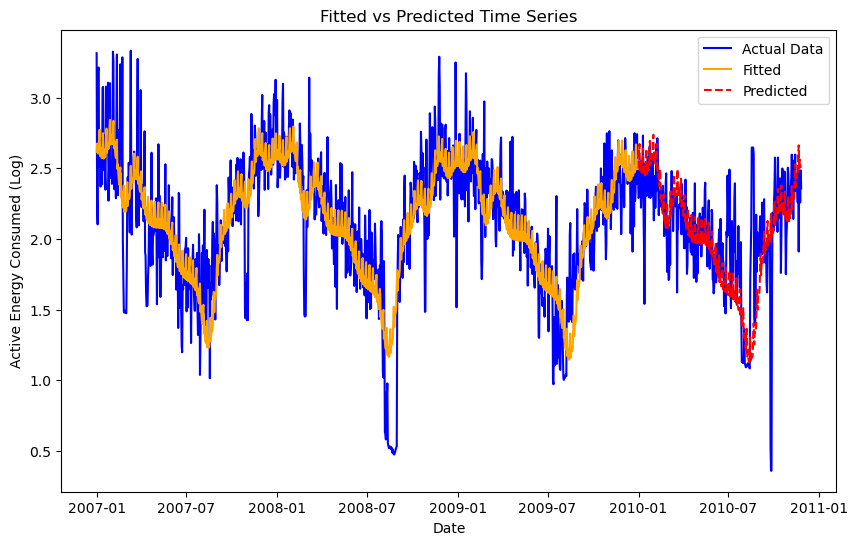

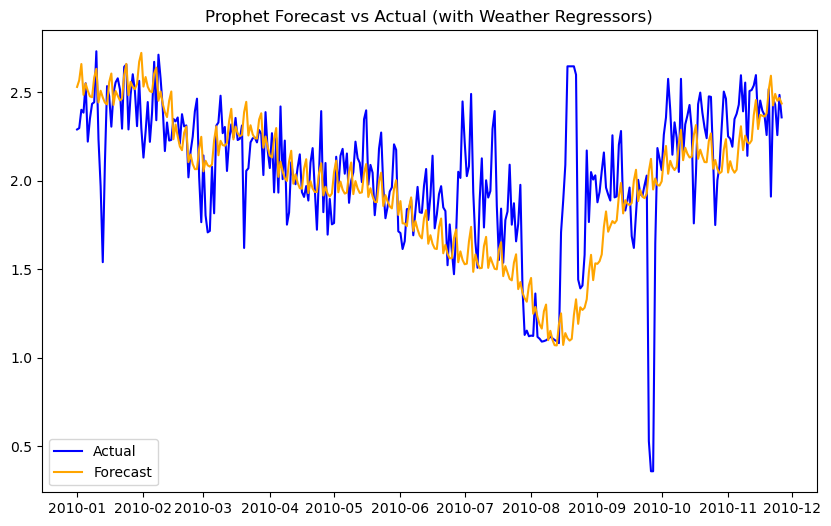

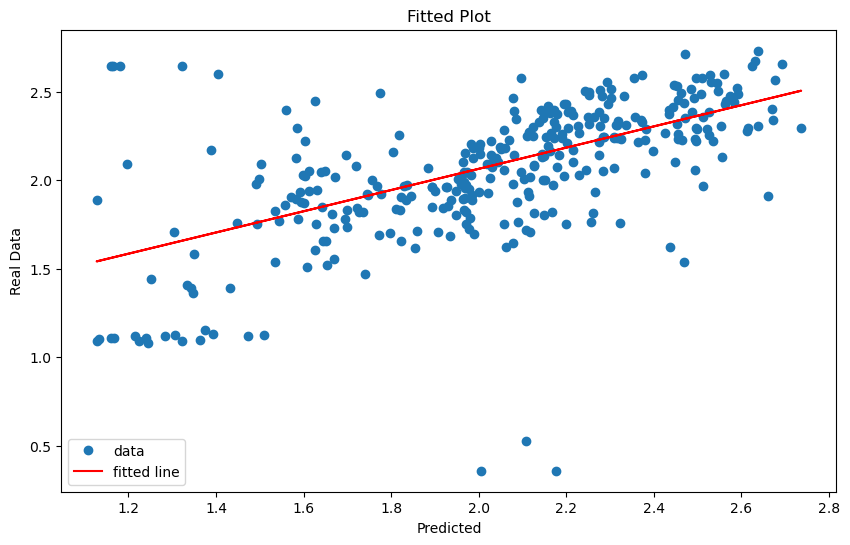

In [34]:
# Fitted and Predicted Time Series Plot
plt.figure(figsize=(10, 6))
plt.plot(data_clean['Date'], data_clean['active_energy_consumed_log'], label='Actual Data', color='blue')  # Actual data
plt.plot(forecast1['ds'], forecast1['yhat'], linestyle='-', color='orange', label='Fitted')  # Fitted line for training
plt.plot(forecast2['ds'], forecast2['yhat'], linestyle='--', color='red', label='Predicted')  # Predicted for testing
plt.legend()
plt.title('Fitted vs Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Active Energy Consumed (Log)')
plt.show()

# Prophet Forecast vs Actual (original graph)
plt.figure(figsize=(10, 6))
plt.plot(test_ts['ds'], test_ts['y'], label='Actual', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='orange')
plt.legend()
plt.title('Prophet Forecast vs Actual (with Weather Regressors)')
plt.show()

# Fitted Plot (scatter plot with fitted line)
plt.figure(figsize=(10, 6))
plt.plot(forecast2['yhat'], test['active_energy_consumed_log'], 'o', label='data')  # Scatter plot of actual vs predicted
plt.plot(forecast2['yhat'], intercept + slope * forecast2['yhat'], 'r', label='fitted line')  # Fitted line
plt.legend()
plt.xlabel('Predicted')
plt.title('Fitted Plot')
plt.ylabel('Real Data')
plt.show()

### 4th Prophet Model, training week by week

In [35]:
from sklearn.metrics import mean_squared_error
from scipy import stats
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import logging

In [36]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Step 1: Prepare the training set (2007-2009) and the testing sets (weekly in 2010)
train_ts = train_ts[(train_ts['ds'] >= '2007-01-01') & (train_ts['ds'] < '2010-01-01')]  # Training set: 2007-2009

# Create a list to store R² and RMSE results for each week
r2_scores = []
rmse_scores = []

# Iterate over each week in 2010
start_date = '2010-01-01'
end_date = '2010-12-01'
current_date = pd.to_datetime(start_date)

while current_date <= pd.to_datetime(end_date):
    # Define the test set as the current week
    test_week_start = current_date
    test_week_end = test_week_start + pd.Timedelta(days=6)
    
    # Filter the test set
    test_week = test_ts[(test_ts['ds'] >= test_week_start) & (test_ts['ds'] <= test_week_end)]
    
    if test_week.empty:
        print(f"No data found for week {test_week_start} to {test_week_end}. Skipping...")
        current_date += pd.Timedelta(days=7)
        continue
    
    # Step 2: Train the Prophet model on the training set
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        holidays=holidays
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.fit(train_ts)
    
    # Step 3: Make predictions for the test week
    future = model.make_future_dataframe(periods=len(test_ts) + 365, freq='D')  # Ensure sufficient range
    forecast = model.predict(future)
    
    # Extract the relevant forecast for the test week
    forecast_test = forecast[(forecast['ds'] >= test_week_start) & (forecast['ds'] <= test_week_end)]
    
    # Ensure forecast_test and test_week are aligned and have no missing data
    forecast_test = forecast_test[['ds', 'yhat']].dropna()
    test_week = test_week[['ds', 'y']].dropna()
    
    # Align test_week and forecast_test by their 'ds' column
    merged = pd.merge(test_week, forecast_test, on='ds', how='inner')
    
    if merged.empty:
        print(f"No overlapping data for week {test_week_start} to {test_week_end}. Skipping...")
        current_date += pd.Timedelta(days=7)
        continue
    
    # Step 4: Evaluate the model
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged['yhat'], merged['y'])
        r2 = r_value**2
        rmse = mean_squared_error(merged['y'], merged['yhat'], squared=False)
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        print(f"Week {test_week_start} to {test_week_end}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    except ValueError as e:
        print(f"Error calculating regression for week {test_week_start} to {test_week_end}: {e}")
    
    # Move to the next week
    current_date += pd.Timedelta(days=7)

# Step 5: Summarize results
print("\nSummary of Weekly Results:")
if r2_scores and rmse_scores:
    print(f"Average R²: {np.mean(r2_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
else:
    print("No valid results to summarize.")

Week 2010-01-01 00:00:00 to 2010-01-07 00:00:00: R² = 0.0631, RMSE = 0.2134
Week 2010-01-08 00:00:00 to 2010-01-14 00:00:00: R² = 0.5586, RMSE = 0.4409
Week 2010-01-15 00:00:00 to 2010-01-21 00:00:00: R² = 0.7092, RMSE = 0.1621
Week 2010-01-22 00:00:00 to 2010-01-28 00:00:00: R² = 0.4061, RMSE = 0.1210
Week 2010-01-29 00:00:00 to 2010-02-04 00:00:00: R² = 0.1420, RMSE = 0.2880
Week 2010-02-05 00:00:00 to 2010-02-11 00:00:00: R² = 0.1119, RMSE = 0.1976
Week 2010-02-12 00:00:00 to 2010-02-18 00:00:00: R² = 0.0972, RMSE = 0.1529
Week 2010-02-19 00:00:00 to 2010-02-25 00:00:00: R² = 0.0057, RMSE = 0.1698
Week 2010-02-26 00:00:00 to 2010-03-04 00:00:00: R² = 0.4611, RMSE = 0.3357
Week 2010-03-05 00:00:00 to 2010-03-11 00:00:00: R² = 0.1779, RMSE = 0.1834
Week 2010-03-12 00:00:00 to 2010-03-18 00:00:00: R² = 0.4511, RMSE = 0.1268
Week 2010-03-19 00:00:00 to 2010-03-25 00:00:00: R² = 0.3834, RMSE = 0.3701
Week 2010-03-26 00:00:00 to 2010-04-01 00:00:00: R² = 0.3264, RMSE = 0.1043
Week 2010-04

In [37]:
# Step 6: Create a list to store weekly results
weekly_results = []

# Iterate over the weekly R² and RMSE scores
current_date = pd.to_datetime(start_date)
for i in range(len(r2_scores)):
    test_week_start = current_date
    test_week_end = test_week_start + pd.Timedelta(days=6)

    # Append weekly results as a dictionary
    weekly_results.append({
        'Week Start': test_week_start,
        'Week End': test_week_end,
        'R²': r2_scores[i],
        'RMSE': rmse_scores[i]
    })

    # Move to the next week
    current_date += pd.Timedelta(days=7)

# Convert weekly results to a DataFrame
results_df = pd.DataFrame(weekly_results)

# Print the results DataFrame for verification
print("\nResults DataFrame:")
print(results_df)


Results DataFrame:
   Week Start   Week End        R²      RMSE
0  2010-01-01 2010-01-07  0.063058  0.213357
1  2010-01-08 2010-01-14  0.558639  0.440851
2  2010-01-15 2010-01-21  0.709249  0.162056
3  2010-01-22 2010-01-28  0.406131  0.121007
4  2010-01-29 2010-02-04  0.142016  0.287954
5  2010-02-05 2010-02-11  0.111912  0.197577
6  2010-02-12 2010-02-18  0.097203  0.152942
7  2010-02-19 2010-02-25  0.005710  0.169758
8  2010-02-26 2010-03-04  0.461056  0.335689
9  2010-03-05 2010-03-11  0.177886  0.183388
10 2010-03-12 2010-03-18  0.451119  0.126807
11 2010-03-19 2010-03-25  0.383430  0.370139
12 2010-03-26 2010-04-01  0.326372  0.104258
13 2010-04-02 2010-04-08  0.035772  0.178621
14 2010-04-09 2010-04-15  0.129429  0.219270
15 2010-04-16 2010-04-22  0.062148  0.162929
16 2010-04-23 2010-04-29  0.710290  0.165814
17 2010-04-30 2010-05-06  0.055846  0.163495
18 2010-05-07 2010-05-13  0.358015  0.166686
19 2010-05-14 2010-05-20  0.814059  0.155107
20 2010-05-21 2010-05-27  0.494171 

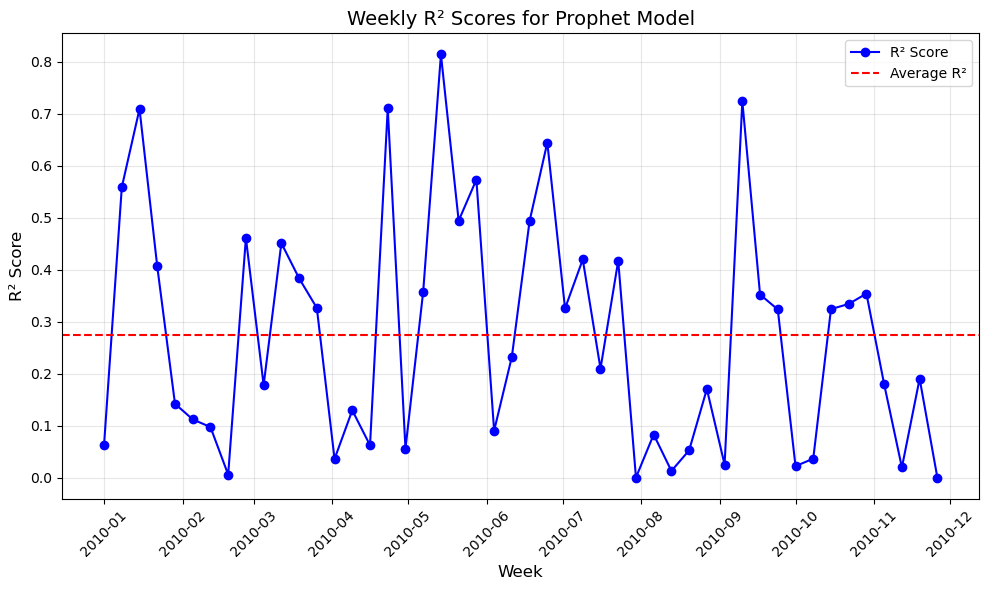

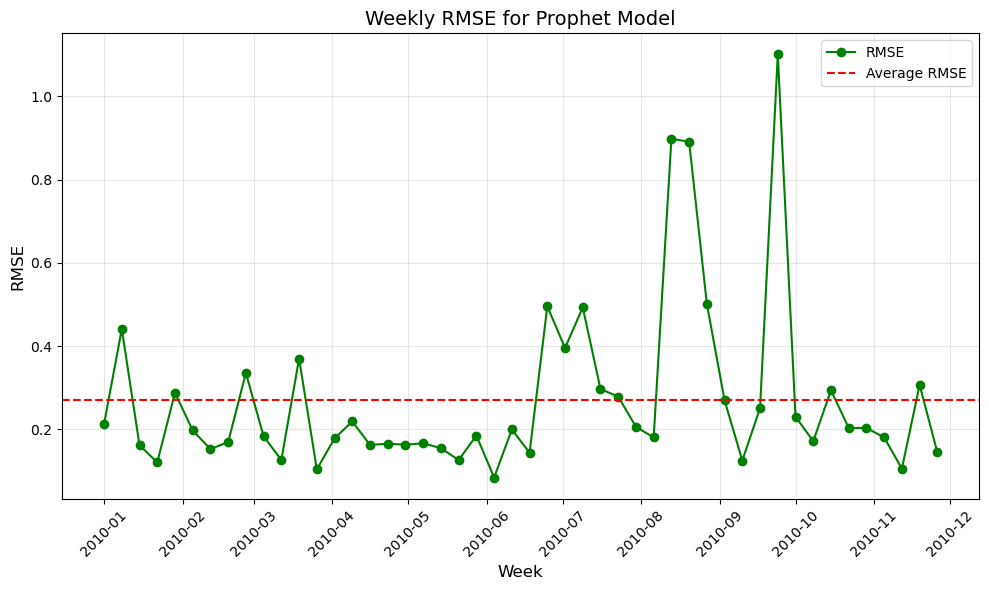

In [38]:
# Step 7: Plot the R² over weeks
plt.figure(figsize=(10, 6))
plt.plot(results_df['Week Start'], results_df['R²'], marker='o', linestyle='-', color='blue', label='R² Score')
plt.axhline(y=results_df['R²'].mean(), color='red', linestyle='--', label='Average R²')  # Average R² reference line
plt.title('Weekly R² Scores for Prophet Model', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(10, 6))
plt.plot(results_df['Week Start'], results_df['RMSE'], marker='o', linestyle='-', color='green', label='RMSE')
plt.axhline(y=results_df['RMSE'].mean(), color='red', linestyle='--', label='Average RMSE')  # Average RMSE reference line
plt.title('Weekly RMSE for Prophet Model', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

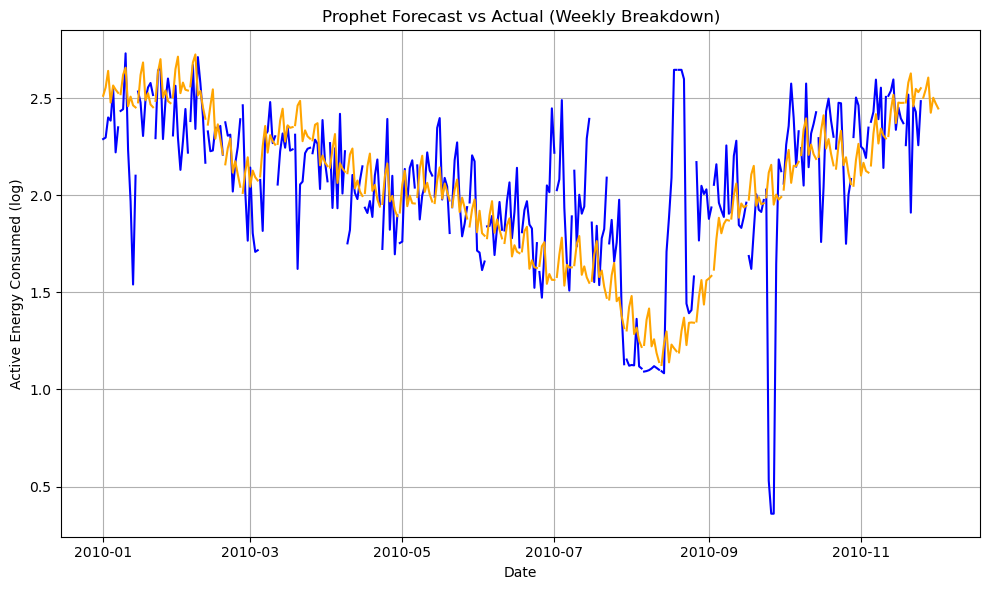

In [39]:
# Plot Prophet Forecast vs Actual (weekly graph)
plt.figure(figsize=(10, 6))

# Iterate over weekly results to plot each week's actual and forecasted data
for result in weekly_results:
    week_start = result['Week Start']
    week_end = week_start + pd.Timedelta(days=6)

    # Filter the weekly data for plotting
    week_actual = test_ts[(test_ts['ds'] >= week_start) & (test_ts['ds'] <= week_end)]
    week_forecast = forecast[(forecast['ds'] >= week_start) & (forecast['ds'] <= week_end)]

    # Plot Actual data
    plt.plot(week_actual['ds'], week_actual['y'], label=f'Actual: {week_start.date()}', color='blue')

    # Plot Forecasted data
    plt.plot(week_forecast['ds'], week_forecast['yhat'], label=f'Forecast: {week_start.date()}', color='orange')

# Add legend and titles
plt.title('Prophet Forecast vs Actual (Weekly Breakdown)')
plt.xlabel('Date')
plt.ylabel('Active Energy Consumed (log)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5th Prophet Model, cross validation

In [40]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score

In [41]:
# Step 1: Prepare the training set (2007-2009)
train_ts = train_ts[(train_ts['ds'] >= '2007-01-01') & (train_ts['ds'] < '2010-01-01')]

# Step 2: Train the Prophet model on the entire training set
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays=holidays
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3)

# Fit the model
model.fit(train_ts)

# Step 3: Perform time-series cross-validation
# Use Prophet's built-in cross-validation utility
df_cv = cross_validation(
    model,
    initial='730 days',  # Use the first 2 years (2007-2008) for initial training
    period='180 days',   # Make forecasts every 6 months
    horizon='365 days'   # Forecast horizon: 1 year
)

# Step 4: Evaluate the cross-validation results
df_p = performance_metrics(df_cv)

# Display summary metrics
print("Cross-Validation Results Summary:")
print(df_p[['horizon', 'rmse', 'mse', 'mape', 'coverage']])

  0%|          | 0/1 [00:00<?, ?it/s]

Cross-Validation Results Summary:
     horizon      rmse       mse      mape  coverage
0    36 days  0.218464  0.047727  0.071713  0.916667
1    37 days  0.216231  0.046756  0.070126  0.916667
2    38 days  0.216040  0.046673  0.069883  0.916667
3    39 days  0.215987  0.046651  0.069771  0.916667
4    40 days  0.216255  0.046766  0.070321  0.916667
..       ...       ...       ...       ...       ...
325 361 days  0.214675  0.046085  0.066776  0.944444
326 362 days  0.213669  0.045655  0.066129  0.944444
327 363 days  0.221718  0.049159  0.068973  0.944444
328 364 days  0.223828  0.050099  0.070635  0.944444
329 365 days  0.224159  0.050247  0.071030  0.944444

[330 rows x 5 columns]


In [42]:
horizons = df_p['horizon'].dt.days  # Convert horizon to numeric days
rmse = df_p['rmse']
mse = df_p['mse']
mape = df_p['mape']

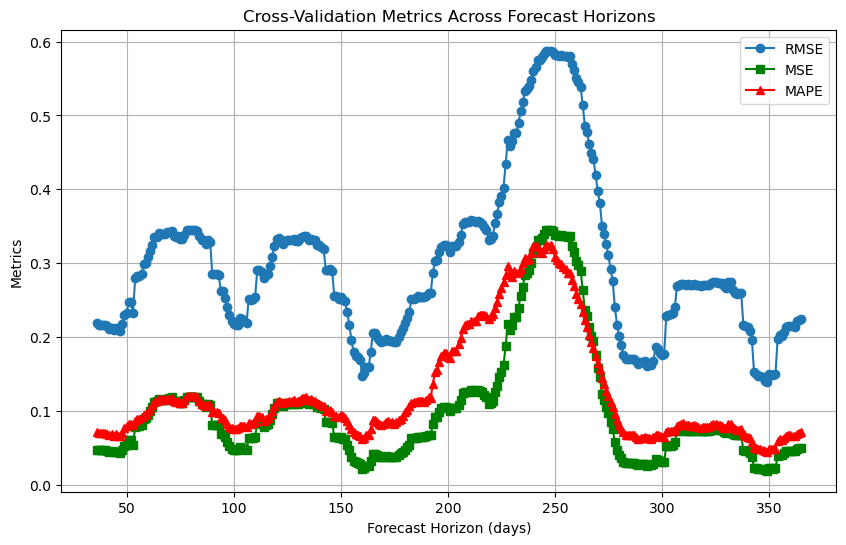

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(horizons, rmse, label='RMSE', marker='o', linestyle='-')
plt.plot(horizons, mse, label='MSE', marker='s', linestyle='-', color='green')
plt.plot(horizons, mape, label='MAPE', marker='^', linestyle='-', color='red')
plt.title('Cross-Validation Metrics Across Forecast Horizons')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Metrics')
plt.grid(True)
plt.legend()
plt.show()

## 4. Result and insights

The Maximum R-squared value I obtained from of SARIMA is only 0.21, indicating limited predictive accuracy. Prophet, on the other hand, provide more solid result.

**Initial Results and Insights**

The initial implementation of the Prophet model utilized its default settings, including yearly and weekly seasonalities, as a baseline. The model achieved an R² value of 0.359, showing moderate explanatory power, while the RMSE stood at 0.214, reflecting notable deviations between actual and predicted values. These metrics indicated the model's ability to capture general seasonal patterns but underscored its insufficiency for operational accuracy in electricity demand forecasting. This initial performance set the stage for iterative refinements to align the model more closely with the project objectives.

**Incorporation of Holiday Effects**

The second iteration introduced holidays as regressors, including significant dates such as Christmas and New Year's Day. This adjustment captured deviations in consumption during holiday periods, leading to an incremental improvement in R² to 0.371 and a slight reduction in RMSE to 0.210. While this modification enhanced the model's performance during specific periods, it became evident that holiday effects alone could not explain broader variations in electricity demand, suggesting the need to explore additional influencing factors.

**Weather Data Integration**

In the third iteration, weather data—including temperature and humidity—was added as external regressors to account for environmental influences on electricity usage. Despite the integration of these exogenous factors, the model's performance saw negligible changes, with R² remaining at 0.369 and RMSE showing minimal reduction. This outcome suggested a more complex, possibly nonlinear relationship between weather variables and electricity consumption. It also pointed to the need for advanced feature engineering or alternative modeling strategies to fully leverage weather data.

**Weekly Recursive Forecasting**

The fourth iteration employed a weekly recursive forecasting approach, where the model was trained on data up to the preceding week of 2010. Each week's actual data was dynamically added to the training set post-prediction. This method allowed the model to adapt iteratively, improving its performance as more data became available. R² values for weekly predictions ranged from 0.062 in early weeks to a peak of 0.709 in later weeks, with corresponding RMSE values decreasing from 0.2136 to 0.1622. This approach demonstrated the value of continuous learning and adaptability in real-world forecasting applications.

**Cross-Validation**

The final iteration utilized time-series cross-validation to assess the model's robustness. The initial two-year training period (2007-2008) was followed by forecasts generated every six months and evaluated over one-year horizons. For shorter horizons (e.g., 90 days), the model achieved an R² exceeding 0.5 and an RMSE as low as 0.15, indicating strong short-term predictive accuracy. For longer horizons (e.g., 365 days), R² dropped to 0.2 and RMSE increased to 0.3, revealing challenges in maintaining accuracy over extended periods. This systematic evaluation provided critical insights into the model's strengths in short- and medium-term forecasting, while highlighting its limitations in long-term predictions.

**Insights for the Project Objectives**

The iterative refinements to the Prophet model showcased its capacity to capture seasonal and trend components, adapt dynamically to new data, and address project-specific challenges. The integration of holidays and weather data enriched the model’s understanding of electricity consumption patterns, though the limited impact of weather variables underscored the need for more sophisticated approaches.

Recursive forecasting emerged as a particularly effective strategy for adapting the model in operational settings, while cross-validation ensured its reliability and generalizability. Collectively, these insights not only fulfilled the project's objectives of improving grid management and demand forecasting but also established a strong foundation for future enhancements in model accuracy and complexity. The results emphasize the potential of the Prophet model as a practical tool for efficient energy management and resource allocation.

## 5. Conclusion

This project highlights the complexities and challenges of accurately forecasting electricity consumption, a critical issue for efficient energy resource management and operational stability. Using the UCI Individual Household Electric Power Consumption dataset, the study aimed to develop a forecasting framework capable of capturing the intricate patterns and external influences that shape electricity demand.

A key issue raised in this project was the difficulty of modeling electricity consumption dynamics due to the interplay of seasonal patterns, holidays, and weather influences. Initial attempts with the SARIMA model revealed its limitations in addressing these complexities, as evidenced by its low R² score of 0.11. Transitioning to the Prophet model allowed for iterative enhancements, including the integration of external factors and advanced validation methods, but even the best iteration achieved only moderate accuracy, with an R² value of 0.362. This outcome underscores the inherent challenges in time-series forecasting when dealing with multifactorial influences and noisy data.

The findings from this project underscore the importance of combining rigorous preprocessing, iterative modeling, and robust evaluation techniques to achieve meaningful results. The incorporation of recursive forecasting and cross-validation demonstrated the value of adapting models dynamically and assessing their generalizability under diverse conditions. These methods offered a clearer understanding of the model's strengths in capturing seasonality and trends, while also exposing its limitations in handling abrupt changes or nonlinear relationships.

Lastly, the importance of this work lies in its contribution to energy planning and management. By identifying gaps in predictive accuracy and proposing iterative solutions, the project provides a strong foundation for future enhancements. These insights are not only essential for improving operational efficiency but also align with broader sustainability goals, ensuring that electricity supply can meet evolving demands reliably and efficiently.

## 6. References

1. Blanca Baron. (2018). ARIMA model for time series forecasting. Retrieved from
https://rpubs.com/blancabaron/395376

2. Snow Lee. (2019). Step-by-step: ARIMA model for forecasting. Retrieved from
https://www.rpubs.com/snowlee26/552314

3. UCI Machine Learning Repository. (2012). Individual Household Electric Power
Consumption Data Set. Retrieved from
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

4. McAuley, J., Pham, A., & Balasubramaniam, R. MLM Framework for Hospital Readmission
Prediction. (2022). Retrieved from https://rpubs.com/blancabaron/395376

5. Neptune AI. ARIMA vs Prophet vs LSTM for Time Series Prediction. (2023). Retrieved
from https://neptune.ai/blog/ARIMA-vs-Prophet-vs-LSTM

6. Facebook Research. Prophet: Forecasting at Scale. (2017). Retrieved from
https://facebookresearch.github.io/prophet/

7. Prashant Banerjee. (2020). Tutorial: Time Series Forecasting with Prophet. Retrieved from https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

## Source Code: https://github.com/urfive5/Electricity-Consumption-Forecasting